<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/Memoria_experiment2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [424]:
!python -m spacy download es_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [425]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [426]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
tqdm.pandas()

from numpy.random import seed
seed(9)

import tensorflow as tf
tf.random.set_seed(9)

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

import nltk
from nltk.tokenize import WordPunctTokenizer
import keras
import re
import string
from collections import Counter

nltk.download("popular")
nltk.download('stopwords')
print(tf.__version__)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [427]:
df = pd.read_csv("gdrive/My Drive/TFG/overviews_final.csv", sep='#',encoding='utf-8', lineterminator='\n')

df.shape

(1054, 8)

In [428]:
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: eval(x))

In [429]:
# Count
ini_n_words = len(Counter(" ".join(df.overview).split()))

In [430]:
X = df.drop(columns=['like'])
y = df['like'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, stratify=y, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=15/95, stratify=y_train, random_state=1) 

X_train = X_train['overview']
X_test = X_test['overview']
X_val = X_val['overview']


vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)
X_val = vectorizer.transform(X_val)

# Test with LogisticRegression
classifier = LogisticRegression(max_iter=300)
classifier.fit(X_train, y_train)

score = classifier.score(X_train, y_train)
print("Accuracy train:", score)

score = classifier.score(X_val, y_val)
print("Accuracy val:", score)

Accuracy train: 1.0
Accuracy val: 0.610062893081761


In [431]:
# Normalización

def normalize(x):
  x = x.lower()
  replacements = (
      ("á", "a"),
      ("é", "e"),
      ("í", "i"),
      ("ó", "o"),
      ("ú", "u"),
      ("ñ", "n")
  )
  for a, b in replacements:
      x = x.replace(a, b)

  x = x.translate(str.maketrans('','',string.punctuation))
  x = x.translate(str.maketrans('','','ªº¡¿'))   
  x = x.replace("  ", " ") 
  return x

In [432]:
df['overview'] = df['overview'].progress_apply(lambda x: normalize(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [normalize(i) for i in x])

In [433]:
# Count
normalize_n_words = len(Counter(" ".join(df.overview).split()))

In [434]:
# Stop_words

stop_words = pd.read_csv("gdrive/My Drive/TFG/stopwords-es.txt",header=None)
stop_words = stop_words[0].tolist()
stop_words = [normalize(word) for word in stop_words]

def delete_stop_words(x):
  words = x.split(' ')
  words = [word for word in words if word not in stop_words]
  x = str(' '.join(words))
  return x

In [435]:
df['overview'] = df['overview'].progress_apply(lambda x: delete_stop_words(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [delete_stop_words(i) for i in x])

In [436]:
# Count
sw_n_words = len(Counter(" ".join(df.overview).split()))

In [437]:
# Lemmatization

import spacy

nlp = spacy.load('es_core_news_sm')

def lemmatize_sentece(sentence):  
  doc = nlp(sentence)
  return ' '.join([word.lemma_ for word in doc])

In [438]:
df_lemma = df.copy()
df_lemma['overview'] = df['overview'].progress_apply(lambda x: lemmatize_sentece(x))
df_lemma['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [lemmatize_sentece(i) for i in x])

In [439]:
# Count
lemma_n_words = len(Counter(" ".join(df_lemma.overview).split()))

In [440]:
# Steaming

from nltk import word_tokenize
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("spanish", ignore_stopwords=True)

def stem_sentence(sentence):
  stemmed_text = [stemmer.stem(word) for word in word_tokenize(sentence)]
  return " ".join(stemmed_text)

In [441]:
df['overview'] = df['overview'].progress_apply(lambda x: stem_sentence(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [stem_sentence(i) for i in x])

In [442]:
df_lemma['overview'] = df_lemma['overview'].progress_apply(lambda x: stem_sentence(x))
df_lemma['new_overviews'] = df_lemma['new_overviews'].progress_apply(lambda x: [stem_sentence(i) for i in x])

In [443]:
# Count
stemming_n_words = len(Counter(" ".join(df.overview).split()))
stemming_lemma_n_words = len(Counter(" ".join(df_lemma.overview).split()))

In [444]:
step = ['Inicio', 'Norm.', 'Stop Words', 'Lemmatization', 'Steamming', 'Lemma. + Steam.']
n_words = [ini_n_words, normalize_n_words, sw_n_words, lemma_n_words, stemming_n_words, stemming_lemma_n_words]

data_count = {
    'Preprocesamiento': step,
    'N palabras': n_words
}

df_count = pd.DataFrame(data=data_count)

In [445]:
n_words

[18990, 13510, 13070, 9821, 8491, 8235]

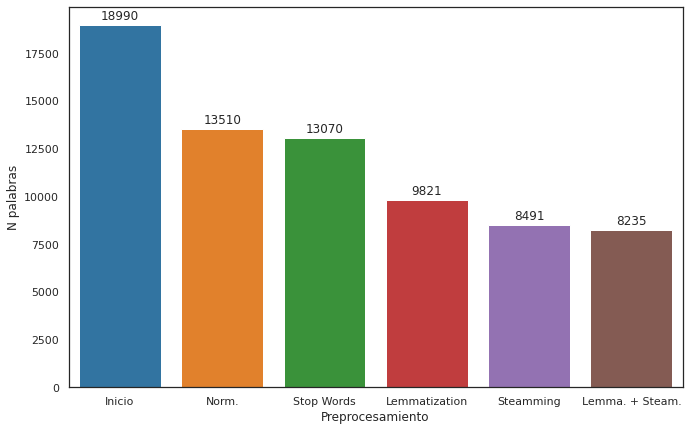

In [446]:
# https://datavizpyr.com/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/

fig, ax = plt.subplots(figsize=(11, 7))
splot = sns.barplot(x="Preprocesamiento", y="N palabras", data=df_count, ax=ax)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

Eligimos combinación (Norm. + SW + Stemming) es la manera más equilibrada en cuanto a rendimiento y cantidad de vocabulario que reducimos. Descartamos por tanto aplicar Lemma.

Nos queamos con un vocabulario de 8491

In [447]:
X = df.drop(columns=['like'])
y = df['like'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, stratify=y, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=15/95, stratify=y_train, random_state=1) 

X_train = X_train['overview']
X_test = X_test['overview']
X_val = X_val['overview']


vectorizer = CountVectorizer(stop_words=stop_words)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)
X_val = vectorizer.transform(X_val)

In [448]:
# Test with LogisticRegression
classifier = LogisticRegression(max_iter=300)
classifier.fit(X_train, y_train)

score = classifier.score(X_train, y_train)
print("Accuracy train:", score)

score = classifier.score(X_val, y_val)
print("Accuracy val:", score)

Accuracy train: 1.0
Accuracy val: 0.6540880503144654
